In [ ]:
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models.feature_extraction import create_feature_extractor,get_graph_node_names
import matplotlib.pyplot as plt
from torchvision.models import vgg16_bn
from torch.utils.data import Subset


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
torch.manual_seed(43)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean =[0.4914, 0.4822, 0.4465],std =[0.2023, 0.1994, 0.2010])
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean =[0.4914, 0.4822, 0.4465],std =[0.2023, 0.1994, 0.2010])
])

In [ ]:
train_dataset = CIFAR10(root = './cifar10', train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root='./cifar10', train=False, download=True, transform=val_transform)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
print(f'train_size is: {len(train_dataset)} , valid_size is: {len(val_dataset)} , test_size is: {len(test_dataset)}')

Files already downloaded and verified
Files already downloaded and verified
train_size is: 45000 , valid_size is: 5000 , test_size is: 10000


In [ ]:
batch_size = 128
# Define DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)



In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
model = VGG16().to(device)
print(model)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [ ]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# end to end training

In [ ]:
epochs = 100
target_val_acc = 0.9
train_loss_list, val_loss_list, train_acc_list, val_acc_list = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss, correct_train, total_train = 0, 0, 0

    with tqdm(total=len(train_loader), desc=f'epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            train_loss += loss.item()

            pbar.set_postfix({'loss': loss.item(), 'acc': correct_train / total_train})
            pbar.update()

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = correct_train / total_train
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)

    scheduler.step()

    # Validation
    model.eval()
    val_loss, correct_val, total_val = 0, 0, 0
    with tqdm(total=len(val_loader), desc=f'Validation', unit='batch') as pbar:
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)
                val_loss += loss.item()

                pbar.set_postfix({'Loss': loss.item(), 'Acc': correct_val / total_val})
                pbar.update()

            avg_val_loss = val_loss / len(val_loader)
            avg_val_acc = correct_val / total_val
            val_loss_list.append(avg_val_loss)
            val_acc_list.append(avg_val_acc)

    if avg_val_acc >= target_val_acc:
        print(f'Target accuracy ({target_val_acc * 100}%) reached')
        break


Validation: 100%|████████████████████████████████████████████| 40/40 [00:01<00:00, 28.49batch/s, Loss=0.0148, Acc=0.909]

Target accuracy (90.0%) reached


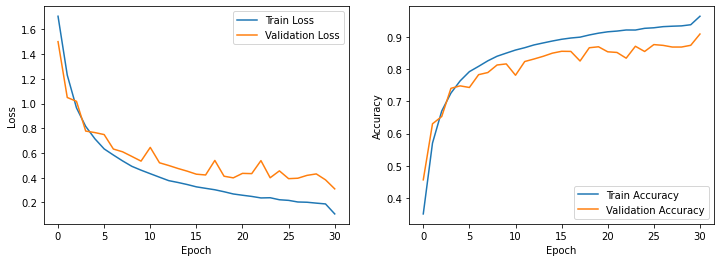

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
model.eval()
correct_test, total_test = 0,0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        _, predicted = torch.max(outputs,1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_accuracy = correct_test / total_test
print(f'test accuracy: {test_accuracy *100:.2f}%')

test accuracy: 91.02%


In [ ]:
best_val_acc = max(val_acc_list)
best_epoch = val_acc_list.index(best_val_acc) + 1  # Add 1 because epochs start from 1

best_model_state = model.state_dict()
torch.save(best_model_state, 'best_model_weights.pth')

additional_info = {
    'epoch': best_epoch,
    'optimizer_state': optimizer.state_dict(),
    'scheduler_state': scheduler.state_dict(),
    # Add more as needed
}

torch.save(additional_info, 'additional_info.pth')

In [ ]:
for num, layer in enumerate(model._modules.keys()):
    print(num , layer)

0 features
1 avgpool
2 classifier


In [ ]:
import torch
from torch.utils.data import Subset, DataLoader

num_classes = 10
samples_per_class_train = 4500 // num_classes
samples_per_class_test = 1000 // num_classes

selected_indices_train = []
class_counter_train = [0] * num_classes

for index, (data, label) in enumerate(train_dataset):
    if class_counter_train[label] < samples_per_class_train:
        selected_indices_train.append(index)
        class_counter_train[label] += 1

    if all(count == samples_per_class_train for count in class_counter_train):
        break

balanced_train_subset = Subset(train_dataset, selected_indices_train)

selected_indices_test = []
class_counter_test = [0] * num_classes

for index, (data, label) in enumerate(test_dataset):
    if class_counter_test[label] < samples_per_class_test:
        selected_indices_test.append(index)
        class_counter_test[label] += 1

    if all(count == samples_per_class_test for count in class_counter_test):
        break

balanced_test_subset = Subset(test_dataset, selected_indices_test)

balanced10_train_loader = DataLoader(balanced_train_subset, batch_size = 3000, shuffle=True)
balanced10_test_loader = DataLoader(balanced_test_subset, batch_size = 1000, shuffle=False)

In [ ]:
def center_si(data, labels, classes):
    data = data.view(data.size(0), -1).to(device)
    class_centers = torch.zeros((len(classes), data.shape[-1]), device = data.device)

    for i in classes:
        data_class = data[labels == i, :]
        class_centers[i, :] = data_class.mean(0)

    center_dist = torch.cdist(data, class_centers, p=2)
    _, indices = torch.sort(center_dist)
    near_class_centers = indices[:, 0]
    correct_data = (labels == near_class_centers) * 1.0

    return correct_data.sum(0) / len(data)

In [ ]:
hooks = []
names = []
for name,module in model.named_modules():
    names.append(name)
    hooks.append(name)
hooks = list(set(hooks).intersection(set(get_graph_node_names(model)[0])))
print((hooks))
print((names))

selected_hook_names = []
selected_hook_classes = []

for module_name, module in model.named_modules():
    if module_name in hooks:
        selected_hook_names.append(module_name)
        selected_hook_classes.append(module.__class__.__name__)

In [ ]:
hooks_si_train = []
layer_names = []
layer_indices = []

#classes = torch.tensor(train_dataset.targets)
imgs, labels = next(iter(balanced10_train_loader))
imgs, labels = imgs.to(device), labels.to(device)

with torch.no_grad():
    for i, hook in enumerate(selected_hook_names):
        hooked_model = create_feature_extractor(model, return_nodes=[hook]).to(device)
        features = hooked_model(imgs)[hook]
#         print(features.shape)
#         print(labels.shape)
        instance = center_si(features, labels, classes= range(10))
        hooks_si_train.append(instance.detach())

        # Store layer name and index for plotting
        layer_names.append(hook)
        layer_indices.append(i)

        print("{:<30} : {} \tcsi = {:.4f}".format(hook, list(features.shape), hooks_si_train[-1]))


features.0                     : [3000, 64, 32, 32] 	csi = 0.3403
features.1                     : [3000, 64, 32, 32] 	csi = 0.3570
features.2                     : [3000, 64, 32, 32] 	csi = 0.3833
features.3                     : [3000, 64, 32, 32] 	csi = 0.3900
features.4                     : [3000, 64, 32, 32] 	csi = 0.4097
features.5                     : [3000, 64, 32, 32] 	csi = 0.4727
features.6                     : [3000, 64, 16, 16] 	csi = 0.4670
features.7                     : [3000, 128, 16, 16] 	csi = 0.4353
features.8                     : [3000, 128, 16, 16] 	csi = 0.4383
features.9                     : [3000, 128, 16, 16] 	csi = 0.5720
features.10                    : [3000, 128, 16, 16] 	csi = 0.5700
features.11                    : [3000, 128, 16, 16] 	csi = 0.5737
features.12                    : [3000, 128, 16, 16] 	csi = 0.6410
features.13                    : [3000, 128, 8, 8] 	csi = 0.6587
features.14                    : [3000, 256, 8, 8] 	csi = 0.6690
featur

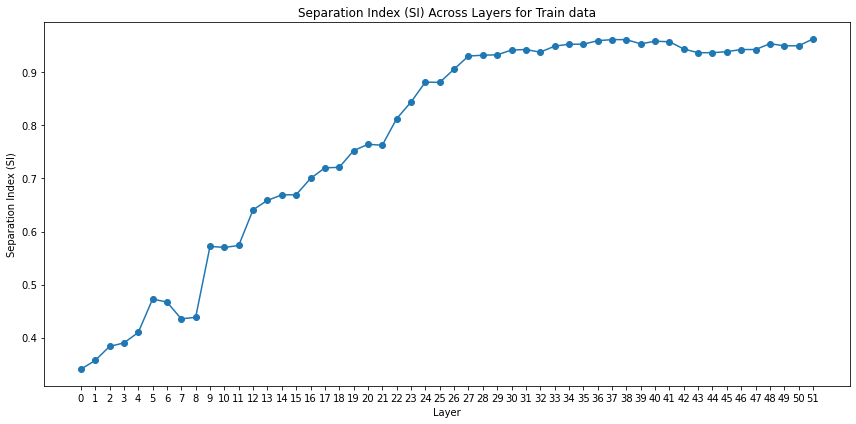

In [ ]:
hooks_si_train = [si.cpu().numpy() for si in hooks_si_train]
plt.figure(figsize=(12, 6))
# Plotting the SI based on the number of layers
plt.plot(layer_indices, hooks_si_train, marker='o')
plt.xticks(layer_indices)
plt.xlabel('Layer')
plt.ylabel('Separation Index (SI)')
plt.title('Separation Index (SI) Across Layers for Train data')
plt.tight_layout()
plt.show()

In [ ]:
hooks_si_test = []

layer_names_test = []
layer_indices_test = []

imgs_test, labels_test = next(iter(balanced10_test_loader))
imgs_test, labels_test = imgs_test.to(device), labels_test.to(device)

with torch.no_grad():
    for i, hook in enumerate(selected_hook_names):
        hooked_model = create_feature_extractor(model, return_nodes=[hook]).to(device)
        features_test = hooked_model(imgs_test)[hook]
        instance_test = center_si(features_test, labels_test, classes= range(10))
        hooks_si_test.append(instance_test.detach())

        # Store layer name and index for plotting
        layer_names_test.append(hook)
        layer_indices_test.append(i)

        print("{:<30} : {} \tsi = {:.4f}".format(hook, list(features_test.shape), hooks_si_test[-1]))


features.0                     : [1000, 64, 32, 32] 	si = 0.3810
features.1                     : [1000, 64, 32, 32] 	si = 0.4140
features.2                     : [1000, 64, 32, 32] 	si = 0.4940
features.3                     : [1000, 64, 32, 32] 	si = 0.5960
features.4                     : [1000, 64, 32, 32] 	si = 0.5890
features.5                     : [1000, 64, 32, 32] 	si = 0.6820
features.6                     : [1000, 64, 16, 16] 	si = 0.6610
features.7                     : [1000, 128, 16, 16] 	si = 0.6520
features.8                     : [1000, 128, 16, 16] 	si = 0.6580
features.9                     : [1000, 128, 16, 16] 	si = 0.7050
features.10                    : [1000, 128, 16, 16] 	si = 0.6830
features.11                    : [1000, 128, 16, 16] 	si = 0.6870
features.12                    : [1000, 128, 16, 16] 	si = 0.7580
features.13                    : [1000, 128, 8, 8] 	si = 0.7450
features.14                    : [1000, 256, 8, 8] 	si = 0.7280
features.15          

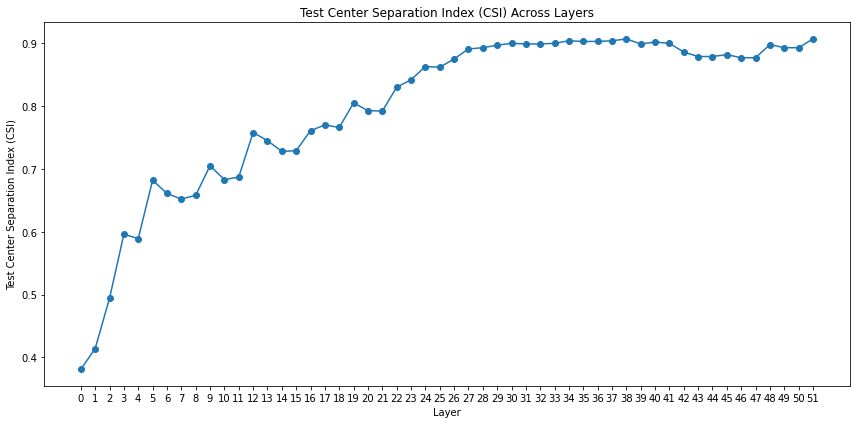

In [ ]:
import matplotlib.pyplot as plt

hooks_si_test = [si.cpu().numpy() for si in hooks_si_test]
plt.figure(figsize=(12, 6))
plt.plot(layer_indices_test, hooks_si_test, marker='o')
plt.xticks(layer_indices_test)
plt.xlabel('Layer')
plt.ylabel('Test Center Separation Index (CSI)')
plt.title('Test Center Separation Index (CSI) Across Layers')
plt.tight_layout()
plt.show()